# 📌 Explainable Radiogenomics for IDH Mutation Prediction On Low Memory GPU's

### 1. Setup and Imports

This cell imports all the necessary libraries for the project. These include packages for deep learning (`PyTorch`, `MONAI`), 3D data handling (`Torchio`), model architectures (`timm_3d`), metrics (`scikit-learn`), data manipulation (`pandas`, `numpy`), and visualization (`matplotlib`, `seaborn`).

In [1]:
import os
import random
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

import timm_3d
import torchinfo
import torchio as tio
from torchcam.methods import GradCAM

import monai
from monai.networks.nets import resnet34
from monai.losses import FocalLoss

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report, precision_score, recall_score,
    roc_auc_score, roc_curve, precision_recall_curve
)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import SimpleITK as sitk
import nibabel as nib
import pyvista as pv

from IPython.display import Image, display

### 2. Load and Inspect Metadata

We begin by loading the project's metadata from the `UCSF-PDGM-metadata_v5.csv` file into a pandas DataFrame. This file is crucial as it contains the patient identifiers and the corresponding ground truth labels (IDH mutation status) for each MRI scan.

We then use `.head()` to display the first few rows, allowing us to quickly inspect the structure of the dataset and verify that it has loaded correctly.

In [3]:
df = pd.read_csv("UCSF-PDGM-metadata_v5.csv")

df.head()

ID Sex  Age at MRI  WHO CNS Grade  \
0  UCSF-PDGM-004   M          66              4   
1  UCSF-PDGM-005   F          80              4   
2  UCSF-PDGM-007   M          70              4   
3  UCSF-PDGM-008   M          70              4   
4  UCSF-PDGM-009   F          68              4   

  Final pathologic diagnosis (WHO 2021)    MGMT status MGMT index   1p/19q  \
0            Glioblastoma, IDH-wildtype       negative          0  unknown   
1            Glioblastoma, IDH-wildtype  indeterminate    unknown  unknown   
2            Glioblastoma, IDH-wildtype  indeterminate    unknown  unknown   
3            Glioblastoma, IDH-wildtype       negative          0  unknown   
4            Glioblastoma, IDH-wildtype       negative          0  unknown   

        IDH  1-dead 0-alive      OS     EOR Biopsy prior to imaging  \
0  wildtype               1  1303.0     STR                      No   
1  wildtype               1   274.0  biopsy                      No   
2  wildtype               1   417.0     STR                      No   
3  wildtype               1   185.0     STR                      No   
4  wildtype               1   389.0     STR                      No   

        BraTS21 ID BraTS21 Segmentation Cohort BraTS21 MGMT Cohort  
0  BraTS2021_00097                    Training            Training  
1              NaN                         NaN                 NaN  
2  BraTS2021_00103                    Training                 NaN  
3              NaN                         NaN                 NaN  
4  BraTS2021_00049                    Training            Training

### 3. Simplify the DataFrame

The original metadata file may contain numerous columns. For the specific task of predicting the IDH mutation status, we only require the patient identifier (`ID`) and the target label (`IDH`).

In this step, we create a new, simplified DataFrame containing only these essential columns. Using `.copy()` ensures that `new_df` is an independent object, which is good practice to prevent unexpected behavior during data manipulation. We then display the head of this new DataFrame to confirm its structure.

In [4]:
new_df = df[['ID', "IDH"]].copy()

new_df.head()

ID       IDH
0  UCSF-PDGM-004  wildtype
1  UCSF-PDGM-005  wildtype
2  UCSF-PDGM-007  wildtype
3  UCSF-PDGM-008  wildtype
4  UCSF-PDGM-009  wildtype

### 4. Convert IDH Status to Binary Labels

For the model to process the target variable, we must convert the categorical `IDH` status into a numerical format. We will perform binary encoding with the following mapping:
- **`0`** → Represents the `wildtype` class.
- **`1`** → Represents the `Mutated` class (encompassing all non-wildtype statuses).

A new `IDH_binary` column is created based on this logic. The original text-based `IDH` column is then dropped to keep the DataFrame clean and ready for the next steps.

Finally, we print the distribution of the binary labels using `.value_counts()` to assess the class balance of our dataset.

In [5]:
new_df['IDH_binary'] = (new_df['IDH'] != 'wildtype').astype(int)

final_df = new_df.drop(['IDH'], axis=1)

print("Final version:")
print(final_df['IDH_binary'].value_counts())

print('-' * 30)
final_df.head()

Final version:
IDH_binary
0    398
1    103
Name: count, dtype: int64
------------------------------


ID  IDH_binary
0  UCSF-PDGM-004           0
1  UCSF-PDGM-005           0
2  UCSF-PDGM-007           0
3  UCSF-PDGM-008           0
4  UCSF-PDGM-009           0

### 5. Visualize Class Distribution

To better understand the class imbalance highlighted by `.value_counts()`, we now create a visual representation.

A pie chart is generated to clearly illustrate the proportion of samples belonging to each class (`Mutated` vs. `Wildtype`). This visualization makes the extent of the class imbalance immediately apparent and underscores the need for mitigation strategies during model training.

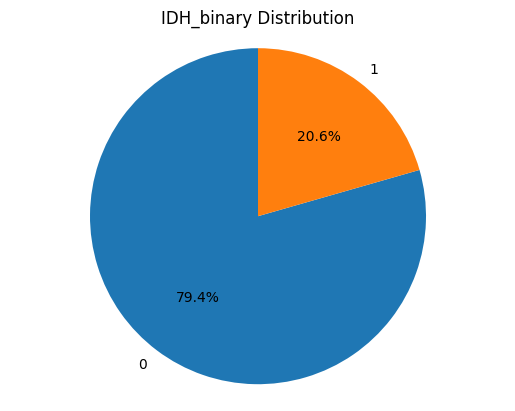

In [6]:
counts = final_df['IDH_binary'].value_counts()

plt.pie(counts, labels=counts.index.astype(str), autopct='%1.1f%%', startangle=90)
plt.title('IDH_binary Distribution')
plt.axis('equal')
plt.show()

### 6. 3D Visualization of a Sample Case

To gain an intuitive understanding of the input data, we will visualize a single patient's MRI scan and tumor segmentation in 3D. This helps in appreciating the spatial relationship between the tumor and the surrounding brain tissue that the model will be learning from.

The process is as follows:
1.  **Load Data**: A sample FLAIR MRI and its corresponding tumor mask (`.nii.gz` files) are loaded using `nibabel`.
2.  **Extract Surfaces**: Using the `pyvista` library, we generate 3D surface meshes from the volumetric data. A contouring algorithm extracts the brain's outer surface from the MRI and the tumor's boundary from the segmentation mask.
3.  **Render Scene**: The brain mesh is rendered as a semi-transparent object, allowing the opaque, brightly colored tumor mesh to be clearly seen within it.
4.  **Create Animation**: An animated GIF is generated by orbiting a virtual camera 360 degrees around the scene, providing a complete view of the 3D model.

The resulting animation is displayed below.

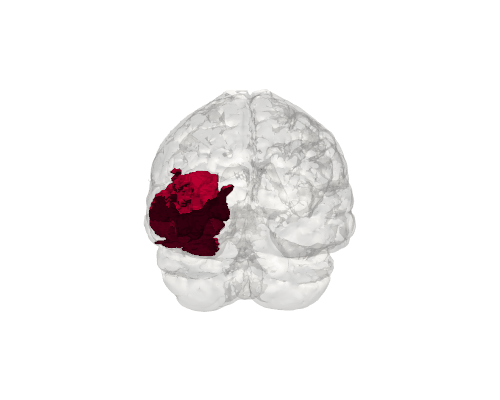

In [7]:
base_path = "PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5/UCSF-PDGM-0032_nifti/"

mri_filename = "UCSF-PDGM-0032_FLAIR_bias.nii.gz"
mri_filepath = os.path.join(base_path, mri_filename)

tumor_mask_filename = "UCSF-PDGM-0032_tumor_segmentation.nii.gz"
tumor_mask_filepath = os.path.join(base_path, tumor_mask_filename)

mri_img = nib.load(mri_filepath)
mri_data = mri_img.get_fdata()

tumor_mask_img = nib.load(tumor_mask_filepath)
tumor_mask_data = tumor_mask_img.get_fdata()

mri_grid = pv.wrap(mri_data)
tumor_grid = pv.wrap(tumor_mask_data)


brain_surface = mri_grid.contour([300]).smooth(n_iter=50, relaxation_factor=0.1)
tumor_surface = tumor_grid.contour([0.5]).smooth(n_iter=30)

plotter = pv.Plotter(off_screen=True, window_size=[500, 400])

plotter.add_mesh(brain_surface, color="white", opacity=0.2, specular=0.3, specular_power=10)
plotter.add_mesh(tumor_surface, color="#c70039", opacity=1.0)
plotter.enable_shadows()

plotter.camera_position = 'iso'

output_filename = "brain_tumor_3rd_person_view.gif"

path = plotter.generate_orbital_path(n_points=72)
plotter.open_gif(output_filename)
plotter.orbit_on_path(path, write_frames=True)
plotter.close()

display(Image(filename=output_filename))

### 7. Split Data into Training, Validation, and Test Sets

To properly train and evaluate our model, we divide the dataset into three distinct subsets:
-   **Training Set**: The data the model learns from (70%).
-   **Validation Set**: Data used to monitor training progress and tune hyperparameters (15%).
-   **Test Set**: Data held back for the final, unbiased evaluation of the model's performance (15%).

We perform a two-step split to achieve this 70/15/15 distribution. Crucially, we use the `stratify` parameter to ensure that the original class distribution (the proportion of `Mutated` vs. `Wildtype` cases) is preserved across all three subsets. This is a critical step when dealing with imbalanced data. A `random_state` is also set to guarantee that the splits are reproducible.

In [8]:
train_df, temp_df = train_test_split(final_df, test_size = 0.3, random_state=42, stratify=final_df['IDH_binary'])

val_df, test_df = train_test_split(temp_df, test_size = 0.5, random_state=42, stratify=temp_df['IDH_binary'])

### 8. Inspecting Raw Image Properties

Before building the full data loading pipeline, it's crucial to inspect the properties of the raw NIfTI files. Medical imaging datasets are often heterogeneous, meaning scans can vary in their dimensions (size) and resolution (spacing).

In this cell, we define and use a helper function, `inspect_single_mri_scan`, to check two key attributes for a sample patient's scans using `SimpleITK`:
-   **Size**: The number of voxels along each axis (width, height, depth).
-   **Spacing**: The physical size of each voxel in millimeters, which defines the image's resolution.

The goal is to verify if all modalities (T1, T1c, T2, FLAIR) and the segmentation mask for a given patient are co-registered—that is, if they already share the same size and spacing. The output will confirm whether a preprocessing step like resampling to a uniform voxel space is necessary to align all the images before they can be processed by the model.

In [9]:
def inspect_single_mri_scan(patient_folder_path, mri_filename):
    
    full_mri_path = os.path.join(patient_folder_path, mri_filename)

    print(f"--- Inspecting File: {full_mri_path} ---")

    if not os.path.exists(full_mri_path):
        print(f"Error: File not found at the specified path.")
        return

    try:
        image = sitk.ReadImage(full_mri_path)
        print("Successfully loaded the image.")
    except Exception as e:
        print(f"An error occurred while trying to read the file: {e}")
        return


    size = image.GetSize()
    print(f"Original Size (in voxels): {size}")

    spacing = image.GetSpacing()
    print(f"Original Spacing (in mm): {spacing}")
    
    print("-------------------------------------------\n")


base_data_directory = "PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5"


patient_folder_name = "UCSF-PDGM-0520_nifti"

patient_id = patient_folder_name.replace("_nifti", "")

patient_folder_path = os.path.join(base_data_directory, patient_folder_name)

core_files = [
    f"{patient_id}_t1.nii.gz",
    f"{patient_id}_t1c.nii.gz",
    f"{patient_id}_t2.nii.gz",
    f"{patient_id}_flair.nii.gz",
    f"{patient_id}_tumor_segmentation.nii.gz"
]

if not os.path.isdir(patient_folder_path):
        print(f"Error: The patient folder was not found at: {patient_folder_path}")
        print("Please check the 'base_data_directory' and 'patient_folder_name' variables.")
else:
    for filename in core_files:
        inspect_single_mri_scan(patient_folder_path, filename)


--- Inspecting File: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5\UCSF-PDGM-0520_nifti\UCSF-PDGM-0520_t1.nii.gz ---
Successfully loaded the image.
Original Size (in voxels): (240, 240, 155)
Original Spacing (in mm): (1.0, 1.0, 1.0)
-------------------------------------------

--- Inspecting File: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5\UCSF-PDGM-0520_nifti\UCSF-PDGM-0520_t1c.nii.gz ---
Successfully loaded the image.
Original Size (in voxels): (240, 240, 155)
Original Spacing (in mm): (1.0, 1.0, 1.0)
-------------------------------------------

--- Inspecting File: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5\UCSF-PDGM-0520_nifti\UCSF-PDGM-0520_t2.nii.gz ---
Successfully loaded the image.
Original Size (in voxels): (240, 240, 155)
Original Spacing (in mm): (1.0, 1.0, 1.0)
-------------------------------------------

--- Inspecting File: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5\UCSF-PDGM-0520_nifti\UCSF-PDGM-0520_flair.nii.gz ---
Successfully loaded the image.
Original Size (in voxels): (240, 240, 155)

### 9. Preprocessing: Define Image Resampling Function

To ensure all inputs to our neural network have a consistent size, we must standardize the dimensions of every scan. The previous inspection step confirmed that raw images are heterogeneous, making this resampling process essential.

This cell defines the `resample_image` utility function, which takes a `SimpleITK` image and resamples it to a uniform target size (e.g., `224x224x128`). A key detail is the choice of interpolation method, which depends on the type of data:

-   **Linear Interpolation (`sitkLinear`)**: Used for the primary MRI scans (FLAIR, T1, etc.). This method provides a smooth, anti-aliased result suitable for continuous intensity values.
-   **Nearest Neighbor Interpolation (`sitkNearestNeighbor`)**: Used exclusively for segmentation masks. This method is critical for masks as it preserves their discrete integer labels (e.g., `0` for background, `1` for tumor) without creating invalid, fractional values that would be introduced by averaging.

The function returns the resampled image as a NumPy array, the standard format for deep learning frameworks.

In [10]:
def resample_image(image, target_size = (224,224,128), is_segmentation=False):

    original_size = image.GetSize()
    original_spacing = image.GetSpacing()

    new_spacing = [
        original_spacing[0] * (original_size[0] / target_size[0]),
        original_spacing[1] * (original_size[1] / target_size[1]),
        original_spacing[2] * (original_size[2] / target_size[2])
    ]

    interpolator = sitk.sitkLinear
    if is_segmentation:
        interpolator = sitk.sitkNearestNeighbor

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(target_size)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetInterpolator(interpolator)

    resampled_image = resampler.Execute(image)

    image_array = sitk.GetArrayFromImage(resampled_image)

    return image_array

### 10. Building the Custom Dataset and DataLoaders

This cell contains the core logic for loading, preprocessing, and augmenting our data. We define a custom PyTorch `Dataset`, specify data augmentations using `torchio`, and create `DataLoaders` that will efficiently feed batches of data to the model, all while handling the significant class imbalance.

#### Data Augmentation with Torchio
To improve model generalization and prevent overfitting, we apply a series of data augmentation techniques to the training data. `torchio` is a library specifically designed for 3D medical images.
-   **`train_transform`**: A rich pipeline of random augmentations—including flips, affine transformations, elastic deformations, and intensity variations—is applied *only* to the training set to create new, realistic training examples.
-   **`test_transform`**: The validation and test sets receive only a simple `ZNormalization` transform. This is crucial because we need a consistent, unbiased evaluation of the model's performance on unmodified data.

#### The Custom `UCSFDataset` Class
We define a custom `UCSFDataset` class that inherits from PyTorch's `Dataset`. Its main responsibilities within the `__getitem__` method are:
1.  **File Loading**: For a given patient ID, it constructs the correct file paths for all specified MRI modalities (FLAIR, T1, etc.).
2.  **Resampling**: It uses our previously defined `resample_image` function to resize all modalities to a consistent dimension (`128x128x128`), which is a memory-conscious choice suitable for the project's constraints.
3.  **Stacking**: It stacks the individual 3D modalities into a single, multi-channel 4D tensor `(channels, depth, width, height)`.
4.  **Applying Transforms**: It applies the appropriate augmentation or normalization pipeline.
5.  **Conditional Mask Loading**: For the test set (`is_test=True`), it also loads and resamples the corresponding tumor segmentation mask. This mask is not used for training but will be vital later for the explainability phase, where we will visualize model attention relative to the tumor's location.

#### Addressing Class Imbalance with `WeightedRandomSampler`
As we saw earlier, our dataset is imbalanced. To prevent the model from simply becoming biased towards the majority class, we implement a weighted sampling strategy for the training loader.
1.  Class weights are calculated, giving a higher weight to the under-represented (minority) class.
2.  The `WeightedRandomSampler` uses these weights to draw samples for each batch. This ensures that, on average, the model sees an equal number of examples from each class during training, leading to more robust learning.

#### Finalizing with DataLoaders
Finally, we wrap our `Dataset` objects in PyTorch `DataLoader`s. These are highly efficient iterators that handle batching, and in the case of the `trainLoader`, integrate the `WeightedRandomSampler` to manage the class imbalance. The data is now fully prepared to be consumed by the model.

In [11]:
class UCSFDataset(Dataset):
    def __init__(self, root_dir, labels_df, is_test, modalities, transform=None):
        self.root_dir = root_dir
        self.labels_df = labels_df
        self.modalities = modalities
        self.transform = transform
        self.is_test = is_test
        self.subject_ids = labels_df['ID'].tolist()

    def __len__(self):
        return len(self.subject_ids)

    def __getitem__(self, idx):
        subject_id = self.subject_ids[idx]
        prefix, number_and_suffix = subject_id.rsplit('-', 1)
        if '_' in number_and_suffix:
            number_str, suffix = number_and_suffix.split('_', 1)
            suffix = f"_{suffix}"
        else:
            number_str = number_and_suffix
            suffix = ""
        number = int(number_str)
        subject_folder = f"{prefix}-{number:04}{suffix}_nifti"
        filename_base = f"{prefix}-{number:04}{suffix}"
        specific_row = self.labels_df[self.labels_df["ID"] == subject_id]
        if not specific_row.empty:
            label = specific_row["IDH_binary"].values[0]
            input_modalities = []
            for modality in self.modalities:
                filename = f"{filename_base}_{modality}.nii.gz"
                filepath = os.path.join(self.root_dir, subject_folder, filename)
                image = sitk.ReadImage(filepath)
                resampledImage = resample_image(image, (128, 128, 128))
                input_modalities.append(resampledImage)
            stacked_images = np.stack(input_modalities, axis = 0)
            image_tensor = torch.from_numpy(stacked_images).float()
            label_tensor = torch.tensor(label, dtype=torch.long)
            final_image_tensor = self.transform(image_tensor)
            if self.is_test:
                segmentation_filename = f"{filename_base}_tumor_segmentation.nii.gz"
                segmentation_filepath = os.path.join(self.root_dir, subject_folder, segmentation_filename)
                seg_image = sitk.ReadImage(segmentation_filepath)
                resampled_seg_image = resample_image(seg_image, (128, 128, 128), is_segmentation=True)
                return final_image_tensor, label_tensor, resampled_seg_image
            else:    
                return final_image_tensor, label_tensor
        else:
            print(subject_id)
            return self[idx + 1]


test_transform = tio.Compose([
    tio.ZNormalization(),
])


train_transform = tio.Compose([
    tio.RandomFlip(axes=('LR',), flip_probability=0.3),
    tio.RandomAffine(scales=(0.9, 1.1), degrees=5, isotropic=False, p=0.3),
    tio.RandomElasticDeformation(num_control_points=7, max_displacement=7.5, p=0.15),
    tio.RandomBiasField(p=0.15),
    tio.RandomGamma(log_gamma=(np.log(0.9), np.log(1.1)), p=0.15),
    tio.RandomNoise(std=(0, 0.025), p=0.15),
    tio.RandomAnisotropy(p=0.1),
    tio.RandomMotion(degrees=10, translation=10, num_transforms=2, p=0.1),
    tio.RandomGhosting(p=0.1),
    tio.RandomSwap(p=0.1, patch_size=15),
    tio.ZNormalization()
])


modalities = ["FLAIR_bias",
              "T1_bias",
              "T1c_bias",
              "T2_bias"
              ]

trainDataset = UCSFDataset(root_dir="PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5", labels_df=train_df, is_test=False, modalities=modalities, transform=train_transform)
testDataset = UCSFDataset(root_dir="PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5", labels_df=test_df, is_test=True, modalities=modalities, transform=test_transform)
valDataset = UCSFDataset(root_dir="PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5", labels_df=val_df, is_test=False, modalities=modalities, transform=test_transform)

# (Assuming your trainDataset is already created)
labels = []
for i in range(len(trainDataset)):
    _, label_tensor = trainDataset[i]
    labels.append(label_tensor.item())

class_counts = Counter(labels)
class_weights = {cls:1.0/count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

print("DataLoader created with WeightedRandomSampler.")
trainLoader = DataLoader(trainDataset, batch_size=16, sampler=sampler, pin_memory=True, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=8, pin_memory=True)
valLoader = DataLoader(valDataset, batch_size=16, pin_memory=True)

DataLoader created with WeightedRandomSampler.


### 11. Visualizing Data Augmentations

To better understand and verify the effects of our `train_transform` pipeline, this cell provides a visual comparison of a single MRI scan before and after augmentation.

The process is as follows:
1.  A sample FLAIR scan is loaded and prepared as a `torchio.Subject`.
2.  The `train_transform` is applied twice to this single subject to generate two unique, randomly augmented versions.
3.  A helper function using `pyvista` renders static 3D surface views of the original (normalized) scan and the two augmented versions.
4.  Finally, `matplotlib` displays these three renderings side-by-side for a direct comparison.

The output below demonstrates the diversity that data augmentation introduces. By training on such varied examples, the model is encouraged to learn the core anatomical and pathological features, rather than memorizing the specific orientation or intensity profiles of the training scans, which ultimately leads to better generalization.

Loading file: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5/UCSF-PDGM-0004_nifti/UCSF-PDGM-0004_FLAIR_bias.nii.gz...
File loaded successfully.
Applying random augmentations...
Generating 3D surface renderings...
Displaying results...


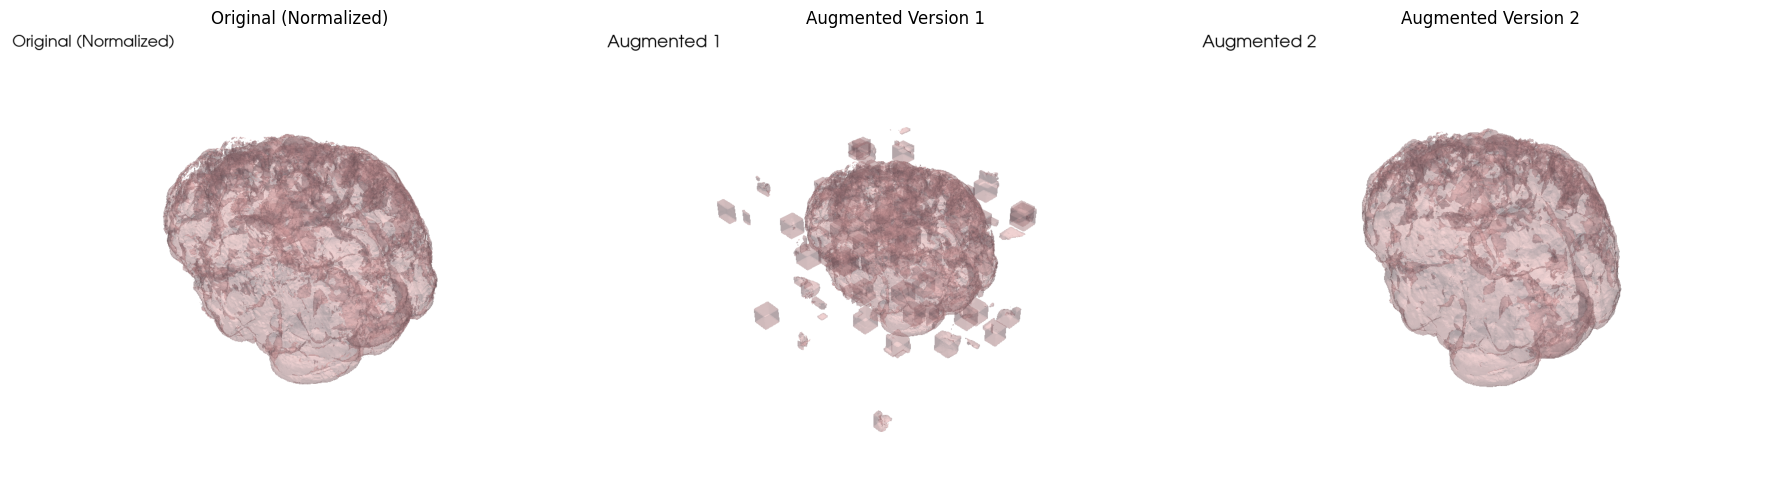

In [11]:
file_path = "PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5/UCSF-PDGM-0004_nifti/UCSF-PDGM-0004_FLAIR_bias.nii.gz"

try:
    print(f"Loading file: {file_path}...")
    mri_img = nib.load(file_path)
    original_np = mri_img.get_fdata()
    print("File loaded successfully.")

    original_tensor = torch.from_numpy(original_np).unsqueeze(0).float()
    original_subject = tio.Subject(mri=tio.ScalarImage(tensor=original_tensor))

    normalizer = tio.ZNormalization()
    normalized_original_subject = normalizer(original_subject)
    original_np_normalized = normalized_original_subject.mri.data[0].cpu().numpy()


    print("Applying random augmentations...")
    augmented_subject_1 = train_transform(original_subject)
    augmented_subject_2 = train_transform(original_subject)

    aug1_np = augmented_subject_1.mri.data[0].cpu().numpy()
    aug2_np = augmented_subject_2.mri.data[0].cpu().numpy()

    def visualize_surface(volume_np, title="Surface"):
        """Creates a static 3D surface plot of a NumPy volume."""
        grid = pv.ImageData()
        grid.dimensions = volume_np.shape
        grid.point_data["values"] = volume_np.flatten(order="F")

        surface_mesh = grid.contour(isosurfaces=[0.5])

        plotter = pv.Plotter(off_screen=True)
        plotter.add_mesh(surface_mesh, color='pink', opacity=0.3)
        plotter.add_text(title, font_size=12)
        plotter.view_isometric()
        return plotter.screenshot()

    print("Generating 3D surface renderings...")
    original_plot = visualize_surface(original_np_normalized, title="Original (Normalized)")
    aug1_plot = visualize_surface(aug1_np, title="Augmented 1")
    aug2_plot = visualize_surface(aug2_np, title="Augmented 2")


    print("Displaying results...")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(original_plot)
    axes[0].set_title("Original (Normalized)")
    axes[0].axis('off')

    axes[1].imshow(aug1_plot)
    axes[1].set_title("Augmented Version 1")
    axes[1].axis('off')

    axes[2].imshow(aug2_plot)
    axes[2].set_title("Augmented Version 2")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"ERROR: The file was not found. Please check the path:\n{file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

### 12. Defining the 3D Classification Model

We now define the architecture of our deep learning model. For this task, we will use a 3D-adapted version of a powerful, pre-trained network: **EfficientNet-B7**, made available through the `timm_3d` library.

Our strategy is based on **transfer learning**. By setting `pretrained=True`, we initialize the model with weights learned on a large-scale image dataset. This allows the model to leverage a rich hierarchy of pre-learned features, which can significantly improve performance and reduce training time, especially on specialized and often smaller medical datasets.

We adapt the standard EfficientNet-B7 architecture for our specific use case:
-   `in_chans=4`: The first layer is modified to accept 4 input channels, corresponding to our stacked FLAIR, T1, T1c, and T2 MRI modalities.
-   `num_classes=2`: The final classifier head is configured to output two values for our binary classification task (IDH Mutated vs. Wildtype).
-   **Regularization**: Dropout and Drop Path rates are included to help prevent the model from overfitting.

Finally, the model is moved to the available `device` (a CUDA-enabled GPU, if detected) to prepare for accelerated training.

In [12]:
try:
    model = timm_3d.create_model(
        'tf_efficientnet_b7.ns_jft_in1k',
        pretrained=True,
        in_chans=4,
        num_classes=2
        ,drop_rate=0.2
        ,drop_path_rate=0.05
    )
    model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print("Model created successfully and moved to device:", device)

except Exception as e:
    print(f"An error occurred: {e}")

Convert layer weights: blocks.0.0.conv_dw.weight. Shape: torch.Size([64, 1, 3, 3]) -> torch.Size([64, 1, 3, 3, 3])
Convert layer weights: blocks.0.0.conv_pw.weight. Shape: torch.Size([32, 64, 1, 1]) -> torch.Size([32, 64, 1, 1, 1])
Convert layer weights: blocks.0.0.se.conv_expand.weight. Shape: torch.Size([64, 16, 1, 1]) -> torch.Size([64, 16, 1, 1, 1])
Convert layer weights: blocks.0.0.se.conv_reduce.weight. Shape: torch.Size([16, 64, 1, 1]) -> torch.Size([16, 64, 1, 1, 1])
Convert layer weights: blocks.0.1.conv_dw.weight. Shape: torch.Size([32, 1, 3, 3]) -> torch.Size([32, 1, 3, 3, 3])
Convert layer weights: blocks.0.1.conv_pw.weight. Shape: torch.Size([32, 32, 1, 1]) -> torch.Size([32, 32, 1, 1, 1])
Convert layer weights: blocks.0.1.se.conv_expand.weight. Shape: torch.Size([32, 8, 1, 1]) -> torch.Size([32, 8, 1, 1, 1])
Convert layer weights: blocks.0.1.se.conv_reduce.weight. Shape: torch.Size([8, 32, 1, 1]) -> torch.Size([8, 32, 1, 1, 1])
Convert layer weights: blocks.0.2.conv_dw.we

### 13. Fine-Tuning Strategy: Freezing Layers

To effectively use our powerful pre-trained model without requiring excessive GPU memory, we will employ a fine-tuning strategy. The core idea is to freeze the majority of the network and only train the final layers that are most responsible for task-specific feature extraction and classification.

The process is as follows:
1.  **Freeze the Entire Network**: We begin by setting `requires_grad = False` for every parameter in the model. This makes all layers non-trainable by default.
2.  **Unfreeze the Top Layers**: We then selectively unfreeze the parameters in the **final two blocks** of the network and the **classifier head**.

This approach offers several key advantages:
-   **Preserves General Features**: It retains the valuable, low-level features (like edges and textures) learned by the early layers on the original large dataset.
-   **Adapts to the Specific Task**: It allows the high-level layers to adapt specifically to recognizing patterns relevant to IDH mutation in brain MRIs.
-   **Reduces Computational Load**: By drastically cutting down the number of trainable parameters, this method significantly lowers GPU memory consumption and speeds up training, making it feasible to run on low-memory hardware.

Finally, we use `torchinfo.summary()` to inspect the model. The summary will validate our setup by showing the total parameters versus the much smaller number of *trainable* parameters.

In [13]:
for parameter in model.parameters():
    parameter.requires_grad = False

for block in model.blocks[-2:]:
    for parameter in block.parameters():
        parameter.requires_grad = True
    
for parameter in model.classifier.parameters():
    parameter.requires_grad = True


torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
EfficientNet                                  --
├─Conv3dSame: 1-1                             (6,912)
├─BatchNormAct3d: 1-2                         128
│    └─Identity: 2-1                          --
│    └─SiLU: 2-2                              --
├─Sequential: 1-3                             --
│    └─Sequential: 2-3                        --
│    │    └─DepthwiseSeparableConv: 3-1       (6,096)
│    │    └─DepthwiseSeparableConv: 3-2       (2,568)
│    │    └─DepthwiseSeparableConv: 3-3       (2,568)
│    │    └─DepthwiseSeparableConv: 3-4       (2,568)
│    └─Sequential: 2-4                        --
│    │    └─InvertedResidual: 3-5             (24,680)
│    │    └─InvertedResidual: 3-6             (43,884)
│    │    └─InvertedResidual: 3-7             (43,884)
│    │    └─InvertedResidual: 3-8             (43,884)
│    │    └─InvertedResidual: 3-9             (43,884)
│    │    └─InvertedResidual: 3-10            (43,884)
│ 

### 14. Defining the Loss, Optimizer, and Scheduler

With the model and data pipeline in place, we now configure the final components required for the training process itself.

#### Loss Function
To effectively handle the class imbalance identified earlier, we will use **Focal Loss**. Unlike standard cross-entropy, Focal Loss dynamically reduces the weight of easy-to-classify examples (which are typically from the majority class). This forces the model to focus its learning on more difficult examples, which often belong to the minority class. The `gamma` parameter controls the strength of this focusing effect.

#### Optimizer
We use the **AdamW** optimizer, a modern variant of Adam that improves generalization by decoupling weight decay from the optimization step. Crucially, we configure the optimizer to update **only the parameters that we unfroze** in the previous step (`p.requires_grad` is `True`). This correctly implements our fine-tuning strategy, ensuring that the frozen layers remain unchanged.

#### Learning Rate Scheduler
To manage the learning rate throughout the training process, we employ the **OneCycleLR** scheduler. This policy is known to improve training stability and speed up convergence. It works by systematically varying the learning rate during training: starting low, warming up to a maximum value, and then gradually decreasing for the remainder of the training run.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Alpha Calculation (Your logic is perfect) ---
# class_counts = train_df['IDH_binary'].value_counts()
# count_class_0_train = class_counts[0]
# count_class_1_train = class_counts[1]
# total_samples_train = count_class_0_train + count_class_1_train

# This is the weight for the positive class (the minority class)
# alpha_for_class_1 = count_class_0_train / total_samples_train

# print(f"Using alpha weight for Focal Loss (positive class): {alpha_for_class_1:.4f}")

criterion = FocalLoss(
    to_onehot_y=True,
    use_softmax=True,
    gamma=2.0
    # ,
    # alpha=alpha_for_class_1  # <-- Use the single float for the positive class
).to(device)


params_to_update = [p for p in model.parameters() if p.requires_grad]
EPOCHS = 50
STEPS_PER_EPOCH = len(trainLoader)
LEARNING_RATE = 1e-4

optimizer = optim.AdamW(params_to_update, lr=LEARNING_RATE, weight_decay=1e-2)

scheduler = OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH
        )

Using alpha weight for Focal Loss (positive class): 0.7943


### 15. The Training and Validation Loop

This cell defines the core `train_model` function that orchestrates the entire training and validation process. The function is designed to be highly robust, incorporating several best practices for a stable and efficient deep learning workflow.

#### Key Features of the `train_model` function:

-   **Combined Train/Validation Phases**: Within each epoch, the model first performs a full pass on the training data to learn and update its weights (`model.train()` mode), followed by a full pass on the validation data to evaluate its generalization performance on unseen data (`model.eval()` mode).

-   **Checkpointing for Resumption**: At the end of every epoch, the function saves a complete checkpoint that includes the model weights, optimizer and scheduler states, and full training history. If the process is interrupted, training can be seamlessly resumed from exactly where it left off.

-   **Best Model Saving**: The function monitors the validation loss and saves a copy of the model's weights to `best_model.pth` only when the model achieves a new best performance. This ensures that we always keep the version of the model that generalized best to the validation set.

-   **Early Stopping**: To prevent overfitting and save computational time, the function includes an early stopping mechanism. If the validation loss fails to improve for a specified number of consecutive epochs (`patience`), the training process is automatically halted.

-   **Gradient Clipping**: To improve training stability, especially with deep networks, gradient clipping is applied during the backward pass. This prevents the gradients from becoming excessively large, which can destabilize the training process.

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, model_path='best_model.pth', checkpoint_path='training_checkpoint.pth',
                patience=5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_val_loss = float('inf') 
    start_epoch = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    trigger_times = 0

    if os.path.exists(checkpoint_path):
        print(f"Resuming training from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        history = checkpoint['history']
        best_val_loss = checkpoint['best_val_loss']
        print(f"Resumed from epoch {start_epoch}")

    # --- 2. MAIN TRAINING LOOP ---
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0 

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        # Gradient Clipping for stability
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        optimizer.step()
                        # Step the scheduler after each batch for OneCycleLR
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0) 
                running_corrects += torch.sum(preds == labels.data) 

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset) 

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else: # Validation phase
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # --- 3. BEST MODEL & EARLY STOPPING LOGIC ---
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    torch.save(model.state_dict(), model_path)
                    print(f'Best model saved to {model_path}')
                    trigger_times = 0 # Reset counter on improvement
                else:
                    trigger_times += 1
                    print(f"EarlyStopping counter: {trigger_times}/{patience}")
                    if trigger_times >= patience:
                        print(f"Early stopping triggered after {patience} epochs with no improvement.")
                        return model, history

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # --- 4. SAVE CHECKPOINT AT THE END OF EACH EPOCH ---
        print("Saving checkpoint...")
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
            'best_val_loss': best_val_loss
        }
        torch.save(checkpoint, checkpoint_path)

    print('Training complete!')
    return model, history

### 16. Start Model Training

With all the necessary components defined—the data loaders, the model architecture, the loss function, the optimizer, and the learning rate scheduler—we are now ready to begin the training process.

This cell calls our `train_model` function to execute the main training loop. The function will run for the specified number of `EPOCHS`, applying our fine-tuning strategy and leveraging features like checkpointing and early stopping.

The output below will show the live progress for each epoch, printing the training and validation loss and accuracy. It will also indicate when a new best model is saved to disk based on improved validation performance. The final trained model and a dictionary containing the performance history will be returned upon completion.

In [16]:
trained_model, training_history = train_model(
    model,
    trainLoader,
    valLoader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=EPOCHS
)

Resuming training from checkpoint: training_checkpoint.pth
Resumed from epoch 7
Epoch 8/50
------------------------------


train: 100%|███████████████████████████████████████████████████████████████████████████| 22/22 [05:33<00:00, 15.16s/it]


train Loss: 0.0734 Acc: 0.6914


val: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.19s/it]


Best model saved to best_model.pth
val Loss: 0.0621 Acc: 0.8267
Saving checkpoint...
Epoch 9/50
------------------------------


train: 100%|███████████████████████████████████████████████████████████████████████████| 22/22 [06:01<00:00, 16.44s/it]


train Loss: 0.0691 Acc: 0.7400


val: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.58s/it]


EarlyStopping counter: 1/5
val Loss: 0.0754 Acc: 0.7200
Saving checkpoint...
Epoch 10/50
------------------------------


train: 100%|███████████████████████████████████████████████████████████████████████████| 22/22 [06:06<00:00, 16.65s/it]


train Loss: 0.0665 Acc: 0.7600


val: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.58s/it]


EarlyStopping counter: 2/5
val Loss: 0.0722 Acc: 0.7333
Saving checkpoint...
Epoch 11/50
------------------------------


train: 100%|███████████████████████████████████████████████████████████████████████████| 22/22 [06:16<00:00, 17.12s/it]


train Loss: 0.0689 Acc: 0.7000


val: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.58s/it]


EarlyStopping counter: 3/5
val Loss: 0.0654 Acc: 0.7200
Saving checkpoint...
Epoch 12/50
------------------------------


train: 100%|███████████████████████████████████████████████████████████████████████████| 22/22 [06:30<00:00, 17.74s/it]


train Loss: 0.0624 Acc: 0.7543


val: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.58s/it]


EarlyStopping counter: 4/5
val Loss: 0.0821 Acc: 0.7200
Saving checkpoint...
Epoch 13/50
------------------------------


train: 100%|███████████████████████████████████████████████████████████████████████████| 22/22 [06:05<00:00, 16.59s/it]


train Loss: 0.0638 Acc: 0.7400


val: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.57s/it]

EarlyStopping counter: 5/5
Early stopping triggered after 5 epochs with no improvement.


### 17. Final Model Evaluation on the Test Set

Now that the training process is complete, the crucial final step is to evaluate our best-performing model on the completely unseen **test set**. This provides an unbiased measure of the model's generalization capabilities and its expected performance on new data.

The `evaluate_model` function defined below performs a thorough and multi-faceted evaluation.

#### The Evaluation Process
The function systematically assesses the model's performance through the following steps:
1.  **Load the Best Model:** It begins by loading the saved weights from `best_model.pth`, ensuring we evaluate the model that achieved the lowest loss on the validation set during training.
2.  **Perform Inference:** It iterates through the entire `testLoader`, making predictions for each sample. This is done within a `torch.no_grad()` block to maximize computational efficiency.
3.  **Calculate Key Metrics:** It computes a comprehensive suite of classification metrics using `scikit-learn`, including Accuracy, Precision, Recall, F1-Score, and the Area Under the Receiver Operating Characteristic Curve (ROC-AUC).
4.  **Generate Visualizations:** To provide deep insights into the model's behavior, it generates several informative plots:
    * A **Confusion Matrix** to visualize the raw counts of correct and incorrect predictions for each class.
    * The **ROC Curve** to assess the model's diagnostic ability across different thresholds.
    * The **Precision-Recall Curve**, which is particularly valuable for understanding performance on imbalanced datasets.
    * A **Per-Class Metrics Bar Chart** to directly compare the Precision, Recall, and F1-score for both the `Wildtype` and `Mutated` classes.

The output of this cell will provide the definitive performance results for our trained model.

In [26]:
def evaluate_model(model, testLoader, model_path='best_model.pth', device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load best model
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels, segs in tqdm(testLoader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:,1]  # probability for positive class

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = None

    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n--- Test Set Performance ---")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    if auc is not None:
        print(f"ROC-AUC  : {auc:.4f}")
    print("----------------------------\n")

    # Confusion Matrix heatmap
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Negative (0)', 'Pred Positive (1)'],
                yticklabels=['Actual Negative (0)', 'Actual Positive (1)'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    if auc is not None:
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()

    # Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_probs)
    plt.figure(figsize=(6,5))
    plt.plot(recall_curve, precision_curve, color='purple', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # Per-class metrics as bar chart
    report = classification_report(all_labels, all_preds, output_dict=True)
    class_names = list(report.keys())[:-3]  # remove avg metrics
    class_precisions = [report[c]['precision'] for c in class_names]
    class_recalls = [report[c]['recall'] for c in class_names]
    class_f1s = [report[c]['f1-score'] for c in class_names]

    x = np.arange(len(class_names))
    width = 0.25

    plt.figure(figsize=(8,5))
    plt.bar(x - width, class_precisions, width, label='Precision')
    plt.bar(x, class_recalls, width, label='Recall')
    plt.bar(x + width, class_f1s, width, label='F1-score')
    plt.xticks(x, class_names)
    plt.ylim(0, 1)
    plt.title('Per-Class Metrics')
    plt.legend()
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': auc,
        'confusion_matrix': cm,
        'classification_report': report
    }
    return metrics


### 18. Run Final Evaluation

We are now ready to execute the final evaluation.

In this cell, we first create a fresh instance of our model architecture. We then pass this model, along with our `testLoader`, to the `evaluate_model` function. The function will automatically load the best-performing weights we saved during training into the model and then run the complete evaluation suite on the held-out test data.

The output will display the full performance report, including the summary table, confusion matrix, ROC curve, and other visualizations, providing the final results for our experiment.

Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.14s/it]



--- Test Set Performance ---
Accuracy : 0.8816
F1 Score : 0.8769
Precision: 0.8762
Recall   : 0.8816
ROC-AUC  : 0.8615
----------------------------



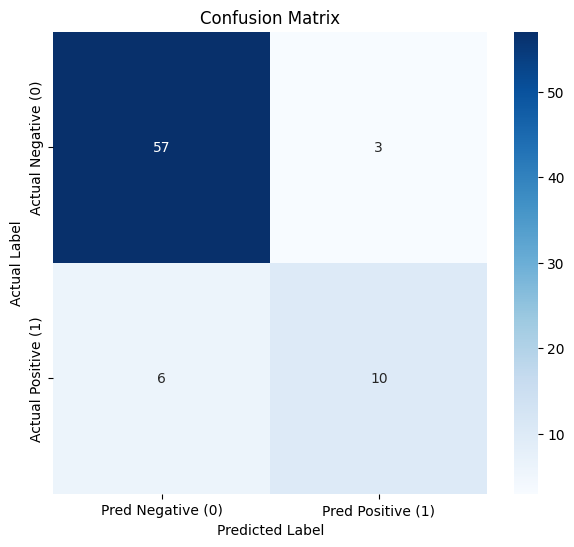

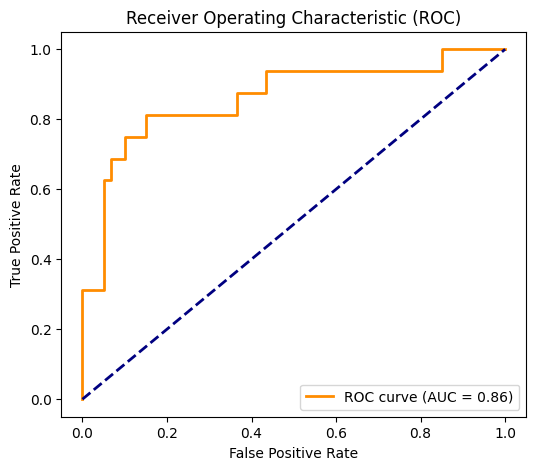

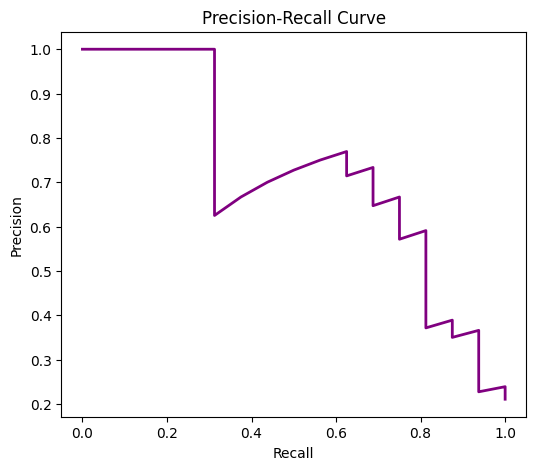

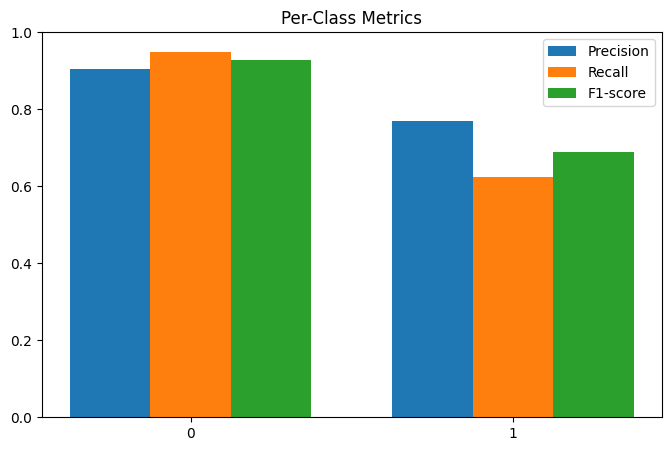

{'accuracy': 0.881578947368421, 'f1_score': 0.8768978796866008, 'precision': 0.8762290341237711, 'recall': 0.881578947368421, 'roc_auc': 0.8614583333333333, 'confusion_matrix': array([[57,  3],
       [ 6, 10]], dtype=int64), 'classification_report': {'0': {'precision': 0.9047619047619048, 'recall': 0.95, 'f1-score': 0.926829268292683, 'support': 60.0}, '1': {'precision': 0.7692307692307693, 'recall': 0.625, 'f1-score': 0.6896551724137931, 'support': 16.0}, 'accuracy': 0.881578947368421, 'macro avg': {'precision': 0.836996336996337, 'recall': 0.7875, 'f1-score': 0.808242220353238, 'support': 76.0}, 'weighted avg': {'precision': 0.8762290341237711, 'recall': 0.881578947368421, 'f1-score': 0.8768978796866008, 'support': 76.0}}}


In [27]:
model_to_evaluate = timm_3d.create_model(
        'tf_efficientnet_b7.ns_jft_in1k',
        pretrained=False,
        in_chans=4,
        num_classes=2
        )
model_to_evaluate.classifier = nn.Linear(in_features=model_to_evaluate.classifier.in_features, out_features=2)
test_metrics = evaluate_model(model_to_evaluate, testLoader, "best_model.pth")
print(test_metrics)

### 19. Visualizing Training History

To analyze the model's learning dynamics over the course of training, we now plot the performance metrics that were recorded at each epoch. The data for these plots is drawn from the `training_history` dictionary returned by our training function.

We will generate two key visualizations:

-   **Training & Validation Loss:** This plot tracks the loss on both the training and validation sets over epochs. Ideally, both curves should decrease and converge. A widening gap between the training and validation loss can be a sign of overfitting.
-   **Training & Validation Accuracy:** This plot shows the accuracy on both datasets. We typically look for both curves to rise and then plateau, which indicates the point at which the model has reached its optimal performance on the given data.

These graphs are essential for diagnosing the health of the training process and visually confirming the model's convergence and generalization performance.

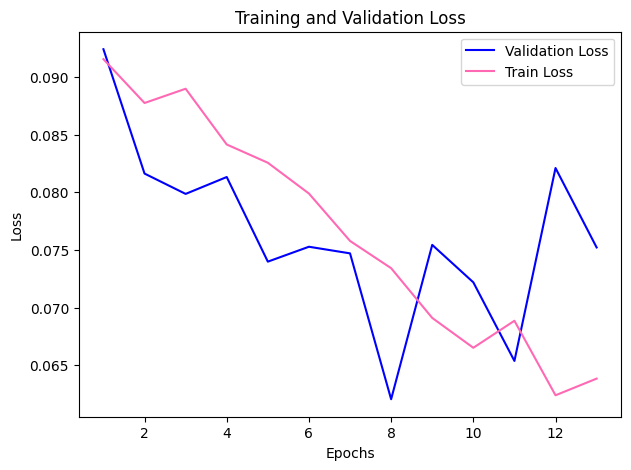

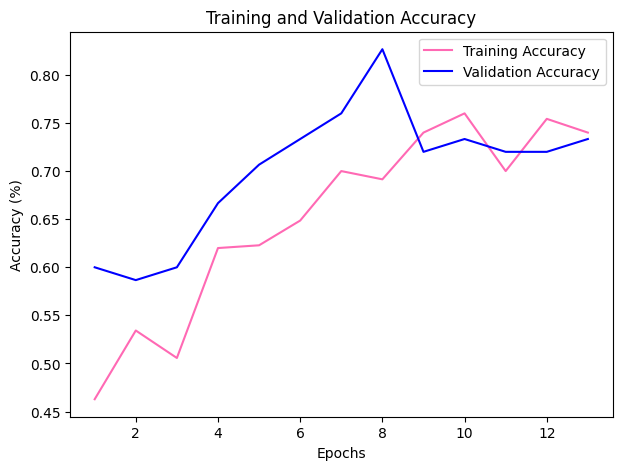

In [20]:
epochs = range(1, 13+1)
# Plot Training and Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(epochs, training_history['val_loss'], color='blue', linestyle='-', label='Validation Loss')
plt.plot(epochs, training_history['train_loss'], color='hotpink', linestyle='-', label='Train Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot_pink_purple.png')
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(epochs, training_history['train_acc'], color='hotpink', linestyle='-', label='Training Accuracy')
plt.plot(epochs, training_history['val_acc'], color='blue', linestyle='-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('accuracy_plot_pink_purple.png')
plt.show()

### 20. Explainable AI (XAI): Visualizing Model Focus with Grad-CAM

A high accuracy score tells us *what* the model predicts, but in medical imaging, it's equally important to understand *why*. This final section addresses the "Explainable" aspect of our project by visualizing the model's decision-making process.

We will use **Gradient-weighted Class Activation Mapping (Grad-CAM)**, a popular Explainable AI (XAI) technique. Grad-CAM produces a heatmap that highlights the regions in the input MRI that were most influential in the model's prediction for a specific class.

#### The XAI Process

The implementation involves three main steps:

1.  **Setup**: We load our best-trained model and initialize a `GradCAM` extractor from the `torchcam` library. We target a deep convolutional layer (`blocks[-2]`) to generate the map, as these final layers capture the most abstract, high-level features that the model uses for classification.

2.  **Generate Heatmap**: A random patient is selected from the test set. After the model makes a prediction, we use the `GradCAM` extractor to generate a coarse heatmap. This map is then upsampled using trilinear interpolation to match the original image's dimensions, allowing for an accurate visual overlay.

3.  **Visualize and Compare**: A custom helper function plots the results in a three-panel view for each of the primary anatomical planes (Axial, Coronal, Sagittal):
    * **Original MRI**: The raw input MRI slice.
    * **Ground Truth Tumor**: The ground truth segmentation mask overlaid on the MRI, showing the actual tumor location.
    * **Model's Focus (Grad-CAM)**: The Grad-CAM heatmap overlaid on the MRI. Hotter colors (red/yellow) indicate regions that strongly influenced the model's decision.

By comparing the "Model's Focus" panel to the "Ground Truth Tumor" panel, we can qualitatively assess our model's reasoning. If the heatmap is concentrated on the tumor, it provides strong evidence that our model has learned to identify clinically relevant pathological features, making its predictions more trustworthy and interpretable.

Loading one random patient for visualization...

--- Visualizing Patient: True Label=0, Predicted=0 ---


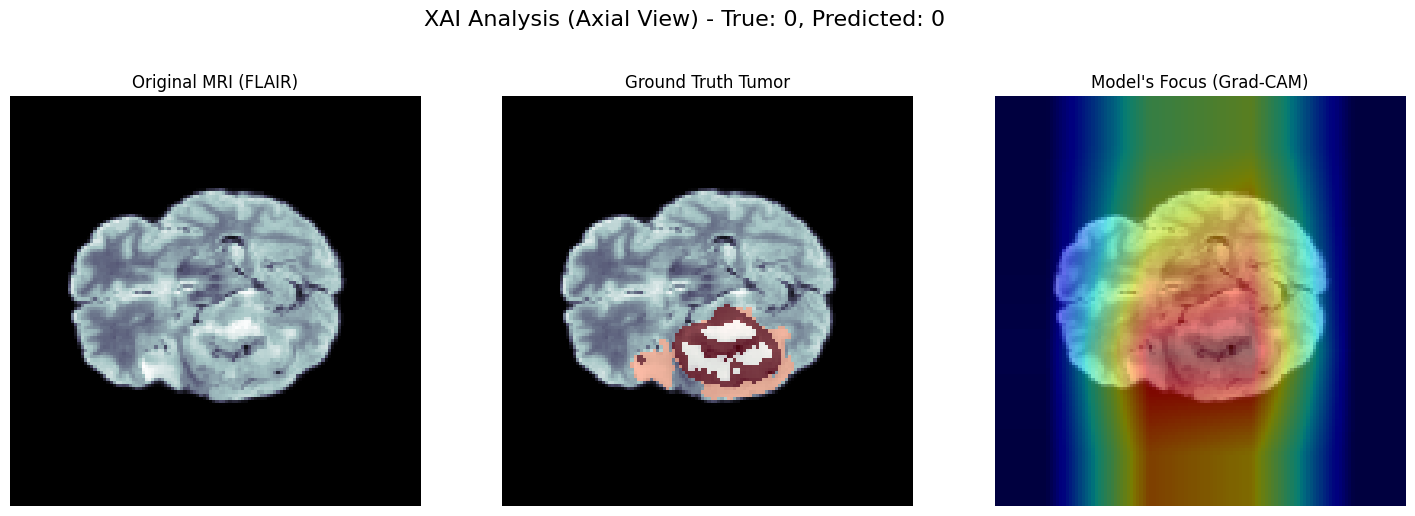

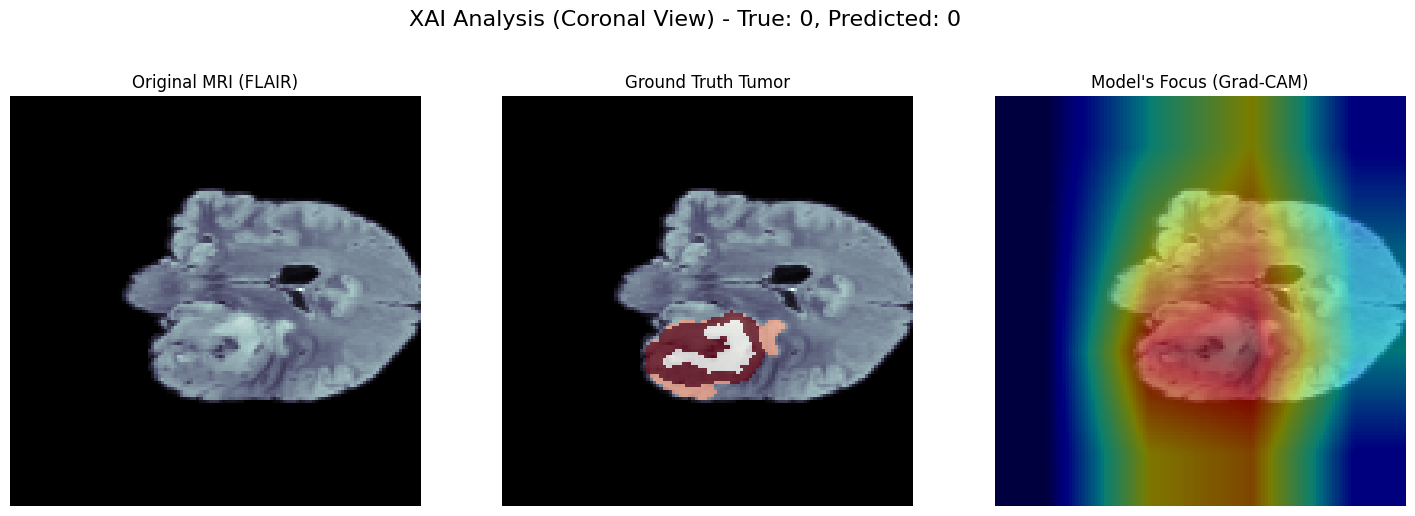

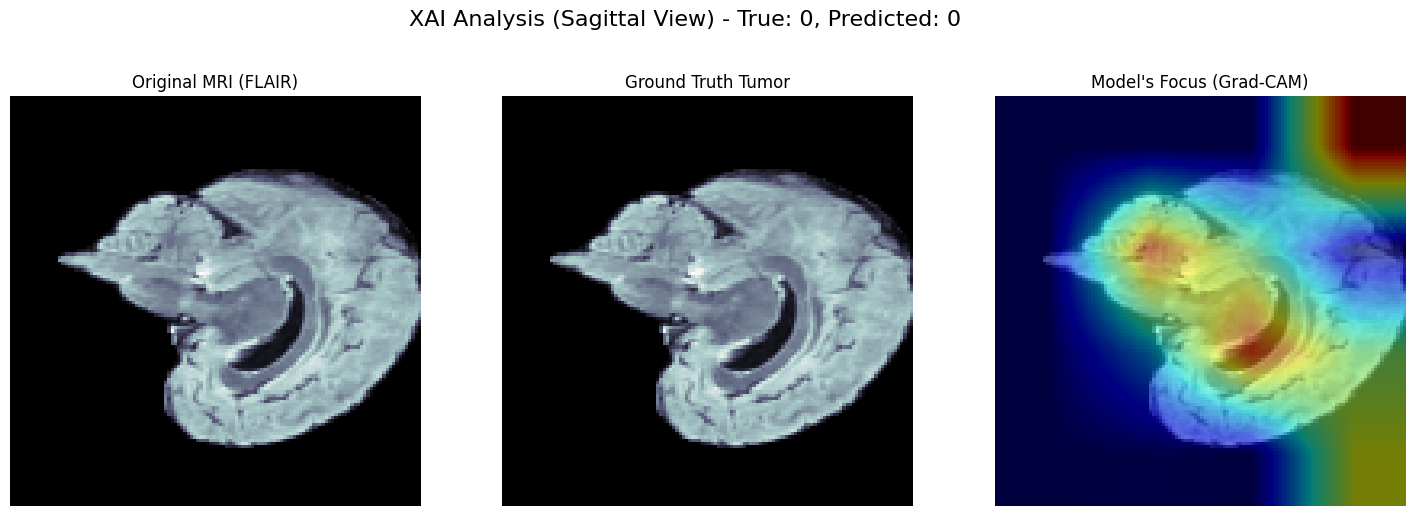

In [15]:
def visualize_cam_and_seg_2d(img_data, cam_data, seg_data, true_label, pred_label, modality_names, slice_axis=0, modality_idx=0):

    if slice_axis == 0: 
        slice_idx = img_data.shape[1] // 2
        brain_slice = img_data[modality_idx, slice_idx, :, :]
        cam_slice = cam_data[slice_idx, :, :]
        seg_slice = seg_data[slice_idx, :, :]
    elif slice_axis == 1: 
        slice_idx = img_data.shape[2] // 2
        brain_slice = img_data[modality_idx, :, slice_idx, :]
        cam_slice = cam_data[:, slice_idx, :]
        seg_slice = seg_data[:, slice_idx, :]
    else: 
        slice_idx = img_data.shape[3] // 2
        brain_slice = img_data[modality_idx, :, :, slice_idx]
        cam_slice = cam_data[:, :, slice_idx]
        seg_slice = seg_data[:, :, slice_idx]

    if cam_slice.max() > cam_slice.min():
        cam_slice = (cam_slice - cam_slice.min()) / (cam_slice.max() - cam_slice.min())

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    view = ["Axial", "Coronal", "Sagittal"][slice_axis]
    modality_name = modality_names[modality_idx]

    axes[0].imshow(brain_slice.T, cmap='bone', origin='lower')
    axes[0].set_title(f'Original MRI ({modality_name})')
    axes[0].axis('off')

    axes[1].imshow(brain_slice.T, cmap='bone', origin='lower')
    axes[1].imshow(np.ma.masked_where(seg_slice.T == 0, seg_slice.T), cmap='Reds', alpha=0.7, origin='lower')
    axes[1].set_title('Ground Truth Tumor')
    axes[1].axis('off')

    axes[2].imshow(brain_slice.T, cmap='bone', origin='lower')
    axes[2].imshow(cam_slice.T, cmap='jet', alpha=0.5, origin='lower')
    axes[2].set_title("Model's Focus (Grad-CAM)")
    axes[2].axis('off')

    plt.suptitle(f"XAI Analysis ({view} View) - True: {true_label}, Predicted: {pred_label}", fontsize=16)
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_to_evaluate = timm_3d.create_model('tf_efficientnet_b7.ns_jft_in1k', pretrained=False, in_chans=4, num_classes=2)
model_to_evaluate.classifier = nn.Linear(in_features=model_to_evaluate.classifier.in_features, out_features=2)
model_to_evaluate.load_state_dict(torch.load("best_model.pth", map_location=device))
model_to_evaluate.to(device)
model_to_evaluate.eval()

vis_loader = DataLoader(testDataset, batch_size=1, shuffle=True)

cam_extractor = GradCAM(model_to_evaluate, model_to_evaluate.blocks[-2]) 

print("Loading one random patient for visualization...")
inputs, labels, segmentation_data = next(iter(vis_loader))
inputs = inputs.to(device)

outputs = model_to_evaluate(inputs)
_, predicted_class = torch.max(outputs, 1)
activation_map_low_res = cam_extractor(predicted_class.item(), outputs)


heatmap_tensor = activation_map_low_res[0].unsqueeze(0) 

heatmap_upsampled = F.interpolate(
    heatmap_tensor, 
    size=(128, 128, 128), 
    mode='trilinear', 
    align_corners=False
)

img_np = inputs[0].detach().cpu().numpy()
cam_np = heatmap_upsampled.squeeze().detach().cpu().numpy()
seg_np = segmentation_data[0].detach().cpu().numpy()
true_label = labels.item()
pred_label = predicted_class.item()

modality_names = ["FLAIR", "T1", "T1c", "T2"]
print(f"\n--- Visualizing Patient: True Label={true_label}, Predicted={pred_label} ---")
visualize_cam_and_seg_2d(img_np, cam_np, seg_np, true_label, pred_label, modality_names, slice_axis=0, modality_idx=0)
visualize_cam_and_seg_2d(img_np, cam_np, seg_np, true_label, pred_label, modality_names, slice_axis=1, modality_idx=0)
visualize_cam_and_seg_2d(img_np, cam_np, seg_np, true_label, pred_label, modality_names, slice_axis=2, modality_idx=0)

cam_extractor.remove_hooks()